# 3. feature engineering
Explore variables using simple OLS to undersand relationships and test transformed variables

### Set up

In [644]:
from __future__ import print_function, division
#Import BeautifulSoup
from bs4 import BeautifulSoup
#Regular expressions compiler
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

import pickle

import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
%matplotlib inline
# %pylab inline

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, lars_path, ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [645]:
#Functions:

#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

In [652]:
with open('pickles/hosp2.pickle','rb') as read_file:
    hosp = pickle.load(read_file)
    
hosp.info()
hosp.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2378 entries, 0 to 2377
Data columns (total 44 columns):
provider_id                                                                          2378 non-null object
start_date                                                                           2378 non-null object
end_date                                                                             2378 non-null object
avg_EXCESS                                                                           2378 non-null float64
avg_PRR                                                                              2378 non-null float64
avg_ERR                                                                              2378 non-null float64
PRR_imputed                                                                          2378 non-null int64
nod_imputed                                                                          2378 non-null int64
number_of_discharges                        

,provider_id,start_date,end_date,avg_EXCESS,avg_PRR,avg_ERR,PRR_imputed,nod_imputed,number_of_discharges,number_of_readmissions,...,safety_of_care_national_comparison_Same_as_the_national_average,patient_experience_national_comparison_Below_the_national_average,patient_experience_national_comparison_Same_as_the_national_average,effectiveness_of_care_national_comparison_Below_the_national_average,effectiveness_of_care_national_comparison_Same_as_the_national_average,timeliness_of_care_national_comparison_Below_the_national_average,timeliness_of_care_national_comparison_Same_as_the_national_average,efficient_use_of_medical_imaging_national_comparison_Below_the_national_average,efficient_use_of_medical_imaging_national_comparison_Same_as_the_national_average,CRTFD_BED_CNT
0,010001,07/01/2014,06/30/2017,1.0454,16.9464,16.2104,0,0,604.0,105.0,...,0,1,0,0,1,0,0,0,1,420
1,010055,07/01/2014,06/30/2017,0.9685,15.1511,15.6442,0,0,580.0,86.0,...,0,0,1,0,1,0,0,0,0,235
2,010005,07/01/2014,06/30/2017,0.9677,15.1414,15.6471,0,0,759.0,113.0,...,0,0,1,0,0,0,0,1,0,240
3,010006,07/01/2014,06/30/2017,0.9817,15.7014,15.9934,0,0,854.0,133.0,...,0,1,0,0,1,0,0,1,0,358
4,010036,07/01/2014,06/30/2017,1.0739,16.7579,15.6041,0,0,315.0,57.0,...,0,1,0,0,1,0,0,0,1,100


In [647]:
#Check correlation of continuous variables

hosp1 = hosp.loc[:,['avg_PRR','number_of_discharges','Case_Mix_Indexes','FY_Wage_Index',
                 '3_Year_Avg_Hourly_Wage','median_household_income','some_college_or_higher','CRTFD_BED_CNT']]

hosp1.corr()

,avg_PRR,number_of_discharges,Case_Mix_Indexes,FY_Wage_Index,3_Year_Avg_Hourly_Wage,median_household_income,some_college_or_higher,CRTFD_BED_CNT
avg_PRR,1.000000,0.128657,0.134470,0.031920,0.021994,-0.095350,-0.154107,0.259913
number_of_discharges,0.128657,1.000000,0.276343,0.096861,0.148365,0.118270,0.130420,0.536585
Case_Mix_Indexes,0.134470,0.276343,1.000000,0.156994,0.301149,0.124249,0.360129,0.561707
FY_Wage_Index,0.031920,0.096861,0.156994,1.000000,0.889830,0.597239,0.363637,0.109440
3_Year_Avg_Hourly_Wage,0.021994,0.148365,0.301149,0.889830,1.000000,0.580116,0.411672,0.229776
median_household_income,-0.095350,0.118270,0.124249,0.597239,0.580116,1.000000,0.685421,0.069600
some_college_or_higher,-0.154107,0.130420,0.360129,0.363637,0.411672,0.685421,1.000000,0.186113
CRTFD_BED_CNT,0.259913,0.536585,0.561707,0.109440,0.229776,0.069600,0.186113,1.000000


In [653]:
#polynomial terms
hosp['CMI2'] = hosp['Case_Mix_Indexes']**2
hosp['NOD2'] = hosp['number_of_discharges']**2
hosp['FWI2'] = hosp['FY_Wage_Index']**2
hosp['MHI2'] = hosp['median_household_income']**2
hosp['SCH2'] = hosp['some_college_or_higher']**2
hosp['BED2'] = hosp['CRTFD_BED_CNT']**2
#interactions
hosp['CMIxNOD'] = hosp['Case_Mix_Indexes']*hosp['number_of_discharges']
hosp['FWIxMHI'] = hosp['FY_Wage_Index']*hosp['median_household_income']
hosp['MHIxSCH'] = hosp['median_household_income']*hosp['some_college_or_higher']
hosp['CMIxSCH'] = hosp['Case_Mix_Indexes']*hosp['some_college_or_higher']
#logs
hosp['MHI_log'] = np.log(hosp['median_household_income'])
hosp['FWI_log'] = np.log(hosp['FY_Wage_Index'])
hosp['NOD_log'] = np.log(hosp['number_of_discharges'])
#log interactions
hosp['FWI_logxMHI_log'] = np.log(hosp['FY_Wage_Index'])*np.log(hosp['median_household_income'])
hosp['CMI_logxSCH_log'] = np.log(hosp['FY_Wage_Index'])*np.log(hosp['median_household_income'])

In [624]:
# Define the model
# lm1 = smf.ols('weighted_avg_PRR ~ FY_2017_Wage_Index + Case_Mix_Indexes + median_household_income', data=hosp)
lm1 = smf.ols('avg_PRR ~ NOD_log', data=hosp)
# Fit the model
fit1 = lm1.fit()
# Print summary statistics of the model's performance
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                avg_PRR   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     50.77
Date:                Wed, 09 Oct 2019   Prob (F-statistic):           1.37e-12
Time:                        19:17:15   Log-Likelihood:                -5079.0
No. Observations:                2378   AIC:                         1.016e+04
Df Residuals:                    2376   BIC:                         1.017e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.6937      0.394     34.722      0.000      12.920      14.467
NOD_log        0.4624      0.065      7.125      0.000       0.335       0.590
==============================================================================
Omnibus:                      100.144   Durbin-Watson:                   1.351
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.681
Skew:                           0.507   Prob(JB):                     3.40e-25
Kurtosis:                       3.330   Cond. No.                         58.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

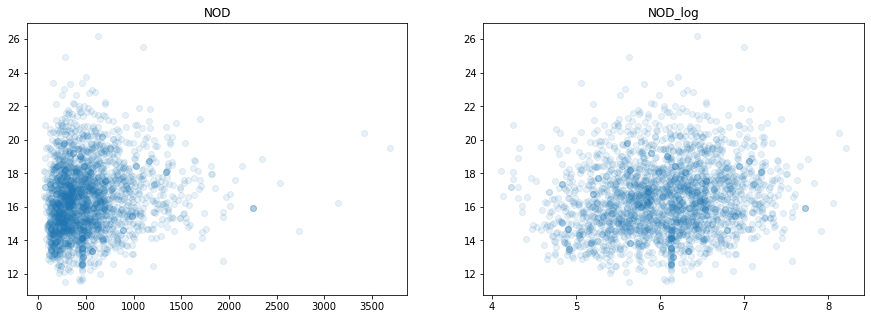

In [625]:
# fig,ax1,ax2 = 
# plt.scatter(hosp['NOD_log'],hosp['avg_PRR'],alpha=0.1);

fig,(ax1,ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.scatter(hosp['number_of_discharges'],hosp['avg_PRR'],alpha=0.1)
ax1.set_title('NOD')
ax2.scatter(hosp['NOD_log'],hosp['avg_PRR'],alpha=0.1)
ax2.set_title('NOD_log');
# ax3.hist(hosp['3_Year_Avg_Hourly_Wage'],hosp['avg_PRR'])
# ax3.set_title('3 yr avg hourly wage');

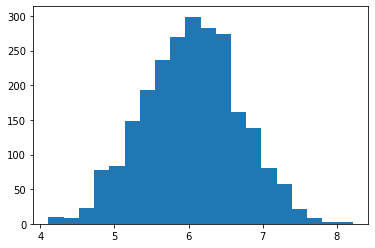

In [626]:
plt.hist(hosp['NOD_log'],bins=20);

In [627]:
# Define the model
# lm1 = smf.ols('weighted_avg_PRR ~ FY_2017_Wage_Index + Case_Mix_Indexes + median_household_income', data=hosp)
lm1 = smf.ols('avg_PRR ~ FWI_log', data=hosp)
# Fit the model
fit1 = lm1.fit()
# Print summary statistics of the model's performance
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                avg_PRR   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.500
Date:                Wed, 09 Oct 2019   Prob (F-statistic):              0.114
Time:                        19:17:15   Log-Likelihood:                -5102.9
No. Observations:                2378   AIC:                         1.021e+04
Df Residuals:                    2376   BIC:                         1.022e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.4958      0.043    385.896      0.000      16.412      16.580
FWI_log        0.3882      0.246      1.581      0.114      -0.093       0.870
==============================================================================
Omnibus:                       85.902   Durbin-Watson:                   1.340
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               94.625
Skew:                           0.473   Prob(JB):                     2.83e-21
Kurtosis:                       3.249   Cond. No.                         5.79
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

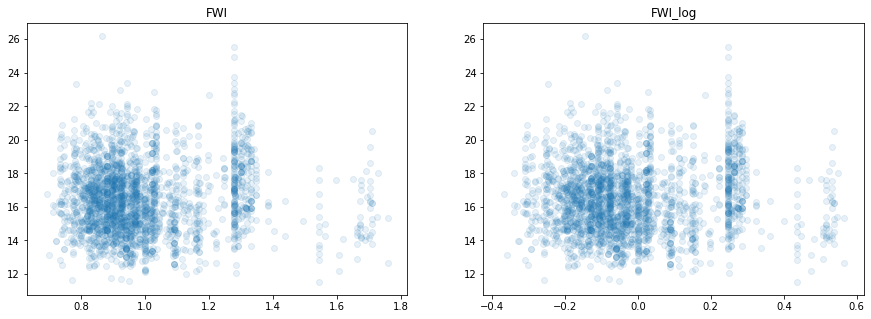

In [628]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.scatter(hosp['FY_Wage_Index'],hosp['avg_PRR'],alpha=0.1)
ax1.set_title('FWI')
ax2.scatter(hosp['FWI_log'],hosp['avg_PRR'],alpha=0.1)
ax2.set_title('FWI_log');

In [629]:
# Define the model
# lm1 = smf.ols('weighted_avg_PRR ~ FY_2017_Wage_Index + Case_Mix_Indexes + median_household_income', data=hosp)
lm1 = smf.ols('avg_PRR ~ median_household_income', data=hosp)
# Fit the model
fit1 = lm1.fit()
# Print summary statistics of the model's performance
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                avg_PRR   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     21.80
Date:                Wed, 09 Oct 2019   Prob (F-statistic):           3.19e-06
Time:                        19:17:16   Log-Likelihood:                -5093.3
No. Observations:                2378   AIC:                         1.019e+04
Df Residuals:                    2376   BIC:                         1.020e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  17.2241      0.163    105.480      0.000      16.904      17.544
median_household_income -1.305e-05    2.8e-06     -4.669      0.000   -1.85e-05   -7.57e-06
==============================================================================
Omnibus:                       88.059   Durbin-Watson:                   1.336
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.177
Skew:                           0.481   Prob(JB):                     7.91e-22
Kurtosis:                       3.237   Cond. No.                     2.26e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.26e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

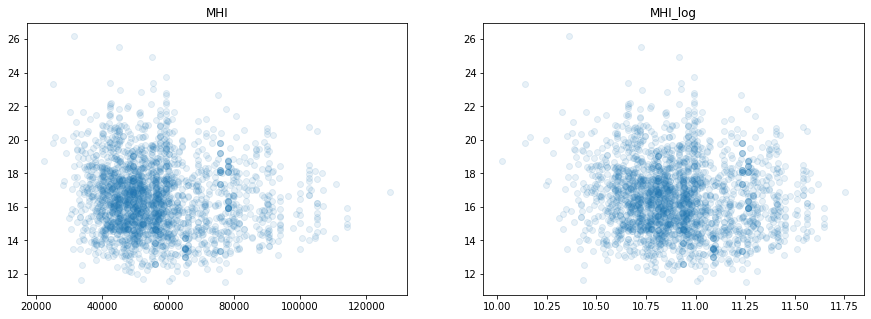

In [630]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.scatter(hosp['median_household_income'],hosp['avg_PRR'],alpha=0.1)
ax1.set_title('MHI')
ax2.scatter(hosp['MHI_log'],hosp['avg_PRR'],alpha=0.1)
ax2.set_title('MHI_log');

In [631]:
# Define the model
# lm1 = smf.ols('weighted_avg_PRR ~ FY_2017_Wage_Index + Case_Mix_Indexes + median_household_income', data=hosp)
lm1 = smf.ols('avg_PRR ~ FWIxMHI', data=hosp)
# Fit the model
fit1 = lm1.fit()
# Print summary statistics of the model's performance
fit1.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                avg_PRR   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.910
Date:                Wed, 09 Oct 2019   Prob (F-statistic):             0.0481
Time:                        19:17:17   Log-Likelihood:                -5102.2
No. Observations:                2378   AIC:                         1.021e+04
Df Residuals:                    2376   BIC:                         1.022e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.6808      0.106    156.695      0.000      16.472      16.890
FWIxMHI    -3.338e-06   1.69e-06     -1.977      0.048   -6.65e-06   -2.78e-08
==============================================================================
Omnibus:                       91.805   Durbin-Watson:                   1.336
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.867
Skew:                           0.489   Prob(JB):                     7.58e-23
Kurtosis:                       3.264   Cond. No.                     1.58e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.58e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [632]:
# Define the model
# lm1 = smf.ols('weighted_avg_PRR ~ FY_2017_Wage_Index + Case_Mix_Indexes + median_household_income', data=hosp)
lm1 = smf.ols('avg_PRR ~ Case_Mix_Indexes', data=hosp)
# Fit the model
fit1 = lm1.fit()
# Print summary statistics of the model's performance
fit1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                avg_PRR   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     43.75
Date:                Wed, 09 Oct 2019   Prob (F-statistic):           4.58e-11
Time:                        19:17:17   Log-Likelihood:                -5082.5
No. Observations:                2378   AIC:                         1.017e+04
Df Residuals:                    2376   BIC:                         1.018e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           14.6344      0.283     51.654      0.000      14.079      15.190
Case_Mix_Indexes     1.1656      0.176      6.615      0.000       0.820       1.511
==============================================================================
Omnibus:                       96.612   Durbin-Watson:                   1.321
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              108.764
Skew:                           0.492   Prob(JB):                     2.41e-24
Kurtosis:                       3.362   Cond. No.                         14.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [660]:
with open('hosp2.pickle','rb') as read_file:
    hosp = pickle.load(read_file)
    
# hosp.info()
# hosp.head(5)

In [661]:
#polynomial terms
hosp['CMI2'] = hosp['Case_Mix_Indexes']**2
hosp['NOD2'] = hosp['number_of_discharges']**2
hosp['FWI2'] = hosp['FY_Wage_Index']**2
hosp['MHI2'] = hosp['median_household_income']**2
hosp['SCH2'] = hosp['some_college_or_higher']**2
hosp['BED2'] = hosp['CRTFD_BED_CNT']**2
#interactions
hosp['CMIxNOD'] = hosp['Case_Mix_Indexes']*hosp['number_of_discharges']
hosp['FWIxMHI'] = hosp['FY_Wage_Index']*hosp['median_household_income']
hosp['MHIxSCH'] = hosp['median_household_income']*hosp['some_college_or_higher']
hosp['CMIxSCH'] = hosp['Case_Mix_Indexes']*hosp['some_college_or_higher']
#logs
hosp['MHI_log'] = np.log(hosp['median_household_income'])
hosp['FWI_log'] = np.log(hosp['FY_Wage_Index'])
hosp['NOD_log'] = np.log(hosp['number_of_discharges'])
#log interactions
hosp['FWI_logxMHI_log'] = np.log(hosp['FY_Wage_Index'])*np.log(hosp['median_household_income'])
hosp['CMI_logxSCH_log'] = np.log(hosp['FY_Wage_Index'])*np.log(hosp['median_household_income'])

In [662]:
#drop data that is not for the model
hosp = hosp.drop(['avg_ERR','avg_EXCESS',
                  'number_of_readmissions','measure_name',
                  'provider_id','start_date','end_date','hospital_name','state',
                  'zip_code','county_name','hospital_type','county_st','3_Year_Avg_Hourly_Wage',
                  'PRR_imputed','nod_imputed'
                 ],axis=1)
#drop the polynomials
hosp = hosp.drop(['CMI2','NOD2','FWI2', 'MHI2', 'SCH2','BED2'],axis=1)

#drop the multicollinear variables
hosp = hosp.drop(['Case_Mix_Indexes','median_household_income','some_college_or_higher'],axis=1)

#drop interactions
hosp = hosp.drop(['MHIxSCH','CMIxSCH','CMIxNOD','FWIxMHI'],axis=1)

#drop log transforms
hosp = hosp.drop(['NOD_log','MHI_log','FWI_log','FWI_logxMHI_log','CMI_logxSCH_log'],axis=1)
#  'CMIxNOD', 'FWIxMHI', 'MHIxSCH'
# hosp = hosp.drop(['CMI2','nod2','FWI2', 'MHI2', 'SCH2', 'CMIxNOD', 'FWIxMHI', 'MHIxSCH'],axis=1)

#drop categoricals
#drop interactions
hosp = hosp.drop(['emergency_services_True'],axis=1)

# #drop all continuous variables except number of discharges 
# hosp = hosp.drop(['avg_ERR','avg_EXCESS',
#                   'number_of_readmissions','measure_name',
#                   'provider_id','start_date','end_date','hospital_name','state',
#                   'zip_code','county_name','hospital_type','county_st','3_Year_Avg_Hourly_Wage',
#                   'PRR_imputed','nod_imputed','Case_Mix_Indexes','FY_Wage_Index',
#                   'some_college_or_higher','median_household_income',
#                   'CMI2','nod2','FWI2', 'MHI2', 'SCH2', 'CMIxNOD', 'FWIxMHI', 'MHIxSCH',
#                  ],axis=1)
# #drop hospital rating variables
hosp = hosp.drop(['hospital_overall_rating_2','hospital_overall_rating_3','hospital_overall_rating_4','hospital_overall_rating_5'],axis=1)

# #drop hospital ownership
hosp = hosp.drop(['hospital_ownership_Nonprofit_Other',
                  'hospital_ownership_Other',
                  'hospital_ownership_Private_Nonprofit',
                  'hospital_ownership_Proprietary',
                  'effectiveness_of_care_national_comparison_Below_the_national_average',
                  'effectiveness_of_care_national_comparison_Same_as_the_national_average',
                  'efficient_use_of_medical_imaging_national_comparison_Below_the_national_average',
                  'efficient_use_of_medical_imaging_national_comparison_Same_as_the_national_average',
                  'mortality_national_comparison_Below_the_national_average',
                  'safety_of_care_national_comparison_Below_the_national_average',
                  'timeliness_of_care_national_comparison_Below_the_national_average',
                  'patient_experience_national_comparison_Below_the_national_average'
                  
                  
                  
                 ],axis=1)
# hosp = hosp.drop(['hospital_ownership_Government__Hospital_District_or_Authority',
#                  'hospital_ownership_Government__Local',
#                  'hospital_ownership_Government__State',
#                  'hospital_ownership_Physician',
#                  'hospital_ownership_Proprietary',
#                  'hospital_ownership_Voluntary_nonprofit__Church',
#                  'hospital_ownership_Voluntary_nonprofit__Other',
#                  'hospital_ownership_Voluntary_nonprofit__Private'],axis=1)

# hosp = hosp.loc[:,['avg_PRR','number_of_discharges','Case_Mix_Indexes','FY_Wage_Index',
#                    'some_college_or_higher','median_household_income',
#                    'emergency_services_True','hospital_ownership_Government__Hospital_District_or_Authority',
#                    'hospital_ownership_Government__Local',
#                    'hospital_ownership_Government__State',
#                    'hospital_ownership_Physician',
#                    'hospital_ownership_Proprietary',
#                    'hospital_ownership_Voluntary_nonprofit__Church',
#                    'hospital_ownership_Voluntary_nonprofit__Other',
#                    'hospital_ownership_Voluntary_nonprofit__Private',
#                    'hospital_overall_rating_2','hospital_overall_rating_3','hospital_overall_rating_4','hospital_overall_rating_5',
# ]]
hosp.head(5)

,avg_PRR,number_of_discharges,FY_Wage_Index,mortality_national_comparison_Same_as_the_national_average,safety_of_care_national_comparison_Same_as_the_national_average,patient_experience_national_comparison_Same_as_the_national_average,timeliness_of_care_national_comparison_Same_as_the_national_average,CRTFD_BED_CNT
0,16.9464,604.0,0.760425,0,0,0,0,420
1,15.1511,580.0,0.754950,0,0,1,0,235
2,15.1414,759.0,0.818375,0,0,1,0,240
3,15.7014,854.0,0.712325,0,0,0,0,358
4,16.7579,315.0,0.692500,1,0,0,0,100


In [663]:
X, y = hosp.iloc[:,1:], hosp['avg_PRR']

# hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state = 9)

In [664]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state = 12)

In [665]:
col_names = ['number_of_discharges','FY_Wage_Index','CRTFD_BED_CNT']

X_features = X[col_names]
X_train_features = X_train[col_names]
X_test_features = X_test[col_names]
X_val_features = X_val[col_names]

ct = ColumnTransformer([
        ('somename', StandardScaler(), ['number_of_discharges','FY_Wage_Index','CRTFD_BED_CNT'])], remainder='passthrough')

ct.fit(X_train_features)

X_1 = ct.transform(X_features)
X_a = ct.transform(X_train_features)
X_b = ct.transform(X_test_features)
X_c = ct.transform(X_val_features)

#pull out the categorical from original data for concatenation with transformed
X_cat = np.array(X.drop(col_names,axis=1))
X_cat_train = np.array(X_train.drop(col_names,axis=1))
X_cat_test = np.array(X_test.drop(col_names,axis=1))
X_cat_val = np.array(X_val.drop(col_names,axis=1))

#concatenate back into one array
X_stan = np.concatenate((X_1,X_cat),axis=1) # full dataset
X_tr = np.concatenate((X_a,X_cat_train),axis=1)
X_te = np.concatenate((X_b,X_cat_test),axis=1)
X_va = np.concatenate((X_c,X_cat_val),axis=1)


In [666]:
std = StandardScaler()


In [638]:
# lm3 = sm.OLS(y_train,X_train)
# X_check = pd.concat((X,y),axis=1)
# # all_columns = " + ".join(X_check.columns[:-1])

# lm3 = smf.ols('avg_PRR ~ number_of_discharges + Case_Mix_Indexes+some_college_or_higher+CRTFD_BED_CNT+FWIxMHI', data=X_check)
# # Fit the model
# fit3 = lm3.fit()
# # Print summary statistics of the model's performance
# fit3.summary()

In [668]:
# lm3 = sm.OLS(y_train,X_train)
X_check = pd.concat((X,y),axis=1)
all_columns = " + ".join(X_check.columns[:-1])

lm3 = smf.ols('avg_PRR ~' + all_columns, data=hosp)
# Fit the model
fit3 = lm3.fit()
# Print summary statistics of the model's performance
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                avg_PRR   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     35.43
Date:                Wed, 09 Oct 2019   Prob (F-statistic):           2.46e-47
Time:                        20:55:57   Log-Likelihood:                -4985.8
No. Observations:                2378   AIC:                             9988.
Df Residuals:                    2370   BIC:                         1.003e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================================
                                                                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                              16.8388      0.254     66.295      0.000      16.341      17.337
number_of_discharges                                                   -0.0003      0.000     -1.981      0.048      -0.001   -2.78e-06
FY_Wage_Index                                                          -0.1566      0.219     -0.716      0.474      -0.586       0.272
mortality_national_comparison_Same_as_the_national_average             -0.4680      0.096     -4.885      0.000      -0.656      -0.280
safety_of_care_national_comparison_Same_as_the_national_average        -0.3525      0.108     -3.252      0.001      -0.565      -0.140
patient_experience_national_comparison_Same_as_the_national_average    -0.2478      0.086     -2.877      0.004      -0.417      -0.079
timeliness_of_care_national_comparison_Same_as_the_national_average    -0.3852      0.085     -4.516      0.000      -0.552      -0.218
CRTFD_BED_CNT                                                           0.0019      0.000      9.941      0.000       0.002       0.002
==============================================================================
Omnibus:                       84.150   Durbin-Watson:                   1.391
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.244
Skew:                           0.456   Prob(JB):                     5.65e-21
Kurtosis:                       3.328   Cond. No.                     5.78e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.78e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [640]:
# lm3 = sm.OLS(y_train,X_train)
# X_check = pd.concat((X,y),axis=1)
# all_columns = " + ".join(X_check.columns[:-1])
# FWIxMHI+number_of_discharges+

# lm3 = smf.ols('avg_PRR ~ number_of_discharges+Case_Mix_Indexes+mortality_national_comparison_Below_the_national_average+safety_of_care_national_comparison_Below_the_national_average+timeliness_of_care_national_comparison_Below_the_national_average', data=X_check)
# # Fit the model
# fit3 = lm3.fit()
# # Print summary statistics of the model's performance
# fit3.summary()

In [641]:
#check where multicolinearity is:
#keep continuous variables for multicolinearity test
# X_vif = hosp.loc[:,['number_of_discharges','Case_Mix_Indexes','FY_Wage_Index',
#                     'median_household_income','some_college_or_higher']]
# X_vif = hosp.loc[:,['number_of_discharges','Case_Mix_Indexes','FY_Wage_Index',
#                     'median_household_income','some_college_or_higher'
#                      ]]
X_vif = X
# X_vif = hosp.loc[:,['NOD_log','CRTFD_BED_CNT','FWIxMHI','Case_Mix_Indexes','some_college_or_higher']]
# 'FWI2', 'MHI2', 'SCH2','CMIxNOD', 'FWIxMHI', 'MHIxSCH'
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif["features"] = X_vif.columns
# X_vif.info()
vif.round(1)

,VIF Factor,features
0,4.7,number_of_discharges
1,14.6,Case_Mix_Indexes
2,3.6,mortality_national_comparison_Same_as_the_nati...
3,1.3,safety_of_care_national_comparison_Same_as_the...
4,1.5,patient_experience_national_comparison_Same_as...
5,1.6,timeliness_of_care_national_comparison_Same_as...
6,4.0,CRTFD_BED_CNT
7,6.4,FWIxMHI


In [642]:
hosp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2378 entries, 0 to 2377
Data columns (total 9 columns):
avg_PRR                                                                2378 non-null float64
number_of_discharges                                                   2378 non-null float64
Case_Mix_Indexes                                                       2378 non-null float64
mortality_national_comparison_Same_as_the_national_average             2378 non-null uint8
safety_of_care_national_comparison_Same_as_the_national_average        2378 non-null uint8
patient_experience_national_comparison_Same_as_the_national_average    2378 non-null uint8
timeliness_of_care_national_comparison_Same_as_the_national_average    2378 non-null uint8
CRTFD_BED_CNT                                                          2378 non-null int64
FWIxMHI                                                                2378 non-null float64
dtypes: float64(4), int64(1), uint8(4)
memory usage: 120.8 KB


In [643]:
# with open('hosp3.pickle', 'wb') as to_write:
#     pickle.dump(hosp, to_write)